In [1]:
import pandas as pd
import json
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tifffile
import imagecodecs
from util import visualize_bbox, visualize
from ipywidgets import interact
from pathlib import Path
from torchvision import models, transforms

# 1. label값 필터링(.json)

In [2]:
# 원본 경로
label_file_path = "./Dataset/01.데이터/1.Training/라벨링데이터_240326_add/콘크리트_콘크리트균열_라벨링_01/"
image_file_path = "./Dataset/01.데이터/1.Training/원천데이터/콘크리트_콘크리트균열_원천_01/"

In [3]:
# 라벨 파일리스트 생성 -> lael_files
label_files = [fn for fn in os.listdir(label_file_path) if fn.endswith('json')]
print(len(label_files))
print(label_files[0])

144194
101_0000149e-4c13-49dd-a77b-c24b3d34a314.json


In [4]:
# 이미지 파일리스트 생성 -> image_files
image_files = [fn for fn in os.listdir(image_file_path) if fn.endswith('tiff')]
len(image_files)

3900

In [5]:
# image_files_파일명
image_files_name = [i.split('.')[0] for i in image_files]
image_files_name
# 이미지01_데이터셋에 맞는 label_files 리스트 생성
new_label_files = []
for i in label_files:
    if i.split('.')[0] in image_files_name:
        new_label_files.append(i)
len(new_label_files)

3900

In [6]:
# 함수1_make_file_list
def make_file_list(path, file):
    file_list = [os.path.join(path, i) for i in  file]
    return file_list

In [7]:
# 데이터셋 파일경로 생성
label_file_list = make_file_list(label_file_path, new_label_files)
image_file_list = make_file_list(image_file_path, image_files)
print(len(label_file_list))
print(len(image_file_list))

3900
3900


In [10]:
folder_name = image_file_list[0].split('/')[-2]
folder_name

'콘크리트_콘크리트균열_원천_01'

# 2. image 데이터셋 생성(tiff -> jpg, 640)

In [51]:
# 이미지 변환 폴더생성
folder_name = image_file_list[0].split('/')[-2]
new_folder_path = Path('./yolo_dataset/resized_images')
new_folder_path.mkdir(parents=True, exist_ok=True)

# 이미지 변환
for idx, img in enumerate(image_file_list):
    image = tifffile.imread(img)
    resize_image = cv2.resize(image, (640,640), interpolation=cv2.INTER_CUBIC)
    img_name = img.split('/')[-1].split('.')[0]
    cv2.imwrite(os.path.join(new_folder_path,f'{img_name}.jpg'), resize_image)
    if idx == 10:
        break

# 2. label 데이터셋 생성(.txt / 클래스 번호 / bbox좌표_정규화)

In [107]:
# 라벨 폴더생성
new_folder_path = Path('./yolo_dataset/txt_labels')
new_folder_path.mkdir(parents=True, exist_ok=True)
# 폴더 경로 설정
txt_folder_path = new_folder_path
# 라벨 .txt파일 생성
for file in label_file_list:
    with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            bbox = [i['bbox'] for i in data['annotations']]
            bbox = [[int(i) for i in li] for li in bbox]
            # 이미지 크기 구하기
            img_w = data['images'][0]['width']
            img_h = data['images'][0]['height']
            # # 이미지 변환 변수
            # w_change = 640 / img_w
            # h_change = 640 / img_h
    file_name = file.split('/')[-1].split('.')[0] + '.txt'
    file_path = os.path.join(new_folder_path, file_name)

    with open(file_path, 'w') as f:
        for bbox_li in bbox:
            x,y,w,h = bbox_li
            # bbox좌표 정규화
            x = x / img_w
            y = y / img_h
            w = w / img_w
            h = h / img_h
            bbox_list = [x,y,w,h]
            bbox_list = [float(i) for i in bbox_list]
            bbox_list = [0] + bbox_list
            result = " ".join(map(str,bbox_list))
            f.write(" ".join(map(str,bbox_list)) + "\n")

# 2. 데이터 체크

In [9]:
# 리스트 테스트
index = 7
print (label_file_list[index])
print (image_file_list[index])

./Dataset/01.데이터/1.Training/라벨링데이터_240326_add/콘크리트_콘크리트균열_라벨링_01/101_008a6339-971e-4220-b216-c49ee9a5bd17.json
./Dataset/01.데이터/1.Training/원천데이터/콘크리트_콘크리트균열_원천_01/101_008a6339-971e-4220-b216-c49ee9a5bd17.tiff


In [104]:
# 바운딩박스 좌표확인
with open(label_file_list[7], 'r', encoding='utf-8') as f:
        data = json.load(f)
bbox = [i['bbox'] for i in data['annotations']]
data['annotations']

[{'id': 1,
  'image_id': 1,
  'category_id': 1,
  'attributes': {'class': 'ConcreteCrack',
   'facility': 'Building',
   'lat': 36.9,
   'lon': 127.9},
  'bbox': [30, 900, 875, 517.5]},
 {'id': 2,
  'image_id': 1,
  'category_id': 1,
  'attributes': {'class': 'ConcreteCrack',
   'facility': 'Building',
   'lat': 36.9,
   'lon': 127.9},
  'bbox': [912.5, 435, 655, 620]},
 {'id': 3,
  'image_id': 1,
  'category_id': 1,
  'attributes': {'class': 'ConcreteCrack',
   'facility': 'Building',
   'lat': 36.9,
   'lon': 127.9},
  'bbox': [1577.5, 45, 690, 530]}]

In [12]:
bbox_rv = [[int(i) for i in li] for li in bbox]
bbox_rv

[[30, 900, 875, 517], [912, 435, 655, 620], [1577, 45, 690, 530]]

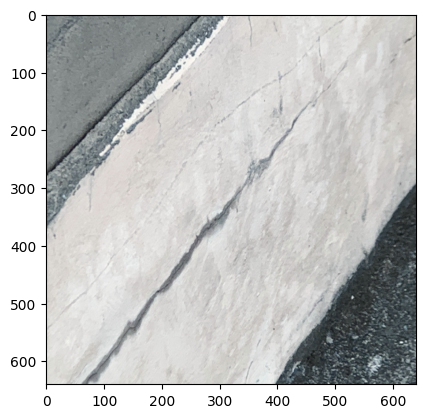

In [13]:
image = tifffile.imread(image_file_list[index])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
dst1 = cv2.resize(image, (640,640), interpolation=cv2.INTER_CUBIC)
plt.imshow(dst1)

In [14]:
# 인덱스별로 이미지 확인 함수
def show_sample(label_file_list, image_file_list, index):
    image = tifffile.imread(image_file_list[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # bbox좌표
    with open(label_file_list[index], 'r', encoding='utf-8') as f:
        data = json.load(f)
        bbox = [i['bbox'] for i in data['annotations']]
        bbox = [[int(i) for i in li] for li in bbox]
    print('image_name : ' + label_file_list[index].split('/')[-1].split('.')[0])
    print(bbox)
    for li in bbox:
        x,y,w,h = li
        cv2.rectangle(image, (x, y), (x+w, y+h), (255,0,0), 7)
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.show()

In [15]:
# 인터랙티브 함수 정의
@interact(index=(0, len(label_file_list)-1))
def interact_image(index):
    show_sample(label_file_list, image_file_list, index)

interactive(children=(IntSlider(value=1949, description='index', max=3899), Output()), _dom_classes=('widget-i…

# 3. 데이터셋 생성

# 0. 이미지 변환

In [96]:
# 인덱스별 이미지 확인함수
def show_640_sample(label_file, image_file, index):
    image = cv2.imread(image_file[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # bbox좌표
    with open(label_file[index], 'r', encoding='utf-8') as f:
    # 한 줄씩 읽기
        for line in f:
            bbox_info = line.strip().split(' ')
            # 클래스 구분
            class_index = int(bbox_info[0])
            # 바운딩박스 좌표
            x, y, w, h = map(int, bbox_info[1:])
            cv2.rectangle(image, (x, y), (x+w, y+h), (255,0,0), 3)
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.show()

In [97]:
# 데이터셋 경로생성함수 
def list_files_in_directory(directory):
    files = []
    for filename in os.listdir(directory):
        filename = os.path.join(directory, filename)
        files.append(filename)
    return files

In [98]:
image_dir = list_files_in_directory("./yolo_dataset/train/images/")
label_dir = list_files_in_directory("./yolo_dataset/train/labels/")
image_dir

['./yolo_dataset/train/images/101_007c8cff-f73f-4670-ab98-304080fc55a1.jpg',
 './yolo_dataset/train/images/101_07a536cd-6a90-420b-a80a-8c729cb6e011.jpg',
 './yolo_dataset/train/images/101_07c67e59-4c34-4d9c-9da4-c51103c6941c.jpg',
 './yolo_dataset/train/images/101_07cb38b4-3369-4aa7-b144-dfb55042f177.jpg',
 './yolo_dataset/train/images/101_07cf8e83-f9df-4ea8-8c64-c3f4278b23b2.jpg',
 './yolo_dataset/train/images/101_07d02ba8-7a9d-4b2e-bdc6-0d613177e45d.jpg',
 './yolo_dataset/train/images/101_07d396dd-0c48-4d2f-a829-4276c02670d9.jpg',
 './yolo_dataset/train/images/101_07d3a062-f1f6-450e-9622-64624a2862e3.jpg',
 './yolo_dataset/train/images/101_07d60c78-91af-4c92-a70c-0f6e960980aa.jpg',
 './yolo_dataset/train/images/101_07e276ba-7cbe-4e21-b0d7-c278967b7067.jpg',
 './yolo_dataset/train/images/101_07ea084a-8545-4486-8d39-a4df6ab2af3e.jpg',
 './yolo_dataset/train/images/101_5eefa504-d6e5-41c0-97ed-f5b3902ab0d3.jpg',
 './yolo_dataset/train/images/101_6a11334c-c233-4e8e-a409-996ce019d175.jpg',

In [99]:
# 인터랙티브 함수 정의
@interact(index=(0, len(label_dir)-1))
def interact_image(index):
    show_640_sample(label_dir, image_dir, index)

interactive(children=(IntSlider(value=1537, description='index', max=3074), Output()), _dom_classes=('widget-i…

In [ ]:
# # 라벨 폴더생성
# new_folder_path = Path('./yolo_dataset/labels')
# new_folder_path.mkdir(parents=True, exist_ok=True)
# # 폴더 경로 설정
# txt_folder_path = new_folder_path
# # 라벨 .txt파일 생성
# for file in label_file_list:
#     with open(file, 'r', encoding='utf-8') as f:
#             data = json.load(f)
#             bbox = [i['bbox'] for i in data['annotations']]
#             bbox = [[int(i) for i in li] for li in bbox]
#     file_name = file.split('/')[-1].split('.')[0] + '.txt'
#     file_path = os.path.join(new_folder_path, file_name)

#     with open(file_path, 'w') as f:
#         for bbox_li in bbox:
#             x,y,w,h = bbox_li
#             bbox_list = [0] + [x,y,w,h]
#             result = " ".join(map(str,bbox_list))
#             f.write(" ".join(map(str,bbox_list)) + "\n")

# 4. train/val 나누기

In [109]:
os.listdir(dataset_img)

['101_0008af00-579e-43ef-a959-d22c3fc591bd.jpg',
 '101_0008b481-3a8b-401f-9698-9df90e143cd0.jpg',
 '101_0008d14e-c4d4-44b6-8017-0292a96fdbe7.jpg',
 '101_007c8cff-f73f-4670-ab98-304080fc55a1.jpg',
 '101_008a111d-56b0-462d-a424-dddcfdca59b6.jpg',
 '101_008a118e-dc21-4ef2-9fc9-5e5eac64197a.jpg',
 '101_008a6197-69ea-4687-8713-dcf80446729f.jpg',
 '101_008a6339-971e-4220-b216-c49ee9a5bd17.jpg',
 '101_008abf7c-e9c9-4486-8cd1-54874de678ea.jpg',
 '101_008bf2de-2299-4cfb-a5fa-17ea18c2daca.jpg',
 '101_008c555a-967d-4955-8b81-9d1d42018fdc.jpg',
 '101_008d0c2f-f0dd-4fda-bc45-d90c597c456f.jpg',
 '101_008d66bc-9979-4b61-b598-c2f97afa72fe.jpg',
 '101_008d7f03-c870-4450-9e90-16be5153f3a3.jpg',
 '101_008d8200-339d-46b0-aca3-5105590ce761.jpg',
 '101_008e4e75-f537-44bc-b426-90b5c0be3e65.jpg',
 '101_008f4887-e236-4339-8176-ab158e34d050.jpg',
 '101_07a536cd-6a90-420b-a80a-8c729cb6e011.jpg',
 '101_07c67e59-4c34-4d9c-9da4-c51103c6941c.jpg',
 '101_07cb38b4-3369-4aa7-b144-dfb55042f177.jpg',
 '101_07cf8e83-f9df-

In [110]:
import os
import random
import shutil

def split_dataset(image_dir, label_dir, train_ratio=0.7):
    # 이미지 및 라벨 파일 리스트 가져오기
    image_files = os.listdir(image_dir)
    label_files = os.listdir(label_dir)
    
    # 이미지 및 라벨 파일 정렬
    image_files.sort()
    label_files.sort()
    
    # 이미지 및 라벨 파일 수
    num_images = len(image_files)
    
    # Train 및 Val 폴더 생성
    os.makedirs('train/images', exist_ok=True)
    os.makedirs('train/labels', exist_ok=True)
    os.makedirs('val/images', exist_ok=True)
    os.makedirs('val/labels', exist_ok=True)
    
    # Train 및 Val 폴더에 이미지 및 라벨 파일 복사
    num_train_images = int(num_images * train_ratio)
    train_image_files = image_files[:num_train_images]
    train_label_files = label_files[:num_train_images]
    val_image_files = image_files[num_train_images:]
    val_label_files = label_files[num_train_images:]
    
    for image_file, label_file in zip(train_image_files, train_label_files):
        shutil.copy(os.path.join(image_dir, image_file), 'train/images')
        shutil.copy(os.path.join(label_dir, label_file), 'train/labels')
        
    for image_file, label_file in zip(val_image_files, val_label_files):
        shutil.copy(os.path.join(image_dir, image_file), 'val/images')
        shutil.copy(os.path.join(label_dir, label_file), 'val/labels')



In [111]:
# 이미지 및 라벨 폴더의 경로 지정
image_dir = './images'
label_dir = './labels'
dataset_img = './crack_dataset/images/'
dataset_label = './crack_dataset/labels/'
# 데이터셋 분할 비율 설정하여 데이터셋 분할
split_dataset(dataset_img, dataset_label, train_ratio=0.7)
